In [5]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import pandas as pd
import xvec

v = 'v3'

regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')

In [6]:
cluster_4_descriptions = {
    1: ("Dense Connected Developments", "In this cluster, buildings frequently share walls forming row-like structures and occupy larger portions of the area. The density of blocks and local street connectivity are moderately high, while inter-building distances remain relatively small. Overall, this configuration yields a dense, tightly arranged environment."),
    2: ("Large Interconnected Blocks", "This cluster is characterized by a high count of connected buildings forming enclosed blocks with courtyards. The covered area ratio is notably high, while street corridors are relatively narrow, resulting in consolidated building formations."),
    3: ("Extensive Courtyard Complexes", "Developments in this cluster exhibit multiple courtyards, numerous connected buildings, and large perimeter walls. Building sizes vary significantly, creating expansive connected areas distinguished by substantial adjacency and courtyard presence."),
    4: ("Massive Connected Aggregations", "This cluster displays very large connected building areas, lengthy perimeter walls, and considerable variability in building sizes. The overall formation covers vast stretches of the built environment with substantial coverage."),
    5: ("Dense Standalone Buildings", "This cluster features a well-connected street layout with a notable proportion of multi-way intersections. Shared walls between buildings are less prevalent, reflecting a pattern of standalone structures within a street network robust network."),
    6: ("Compact Development", "Development in this cluster is characterised by a moderate number of buildings and relatively dense local street connectivity. Shared walls appear regularly, and Inter-building distances are relatively small, suggesting a compact layout."),
    7: ("Cul-de-Sac Layout", "This cluster is distinguished by a significant presence of cul-de-sacs and relatively modest building coverage. Although local node density is moderate, the overall street network is not highly interconnected."),
    8: ("Aligned Winding Streets", "Here, buildings exhibit a consistent alignment along streets of varying width. However, the overall street connectivity is lower than average, leading to a moderately ordered but less connected layout."),
    9: ("Sparse Rural Development", "Developments in this cluster have greater distances between buildings and street nodes. Streets are often wider, and adjacency is comparatively low."),
    10: ("Large Wide-Spaced Complexes", "This cluster is defined by substantial building footprints, relatively wide streets, and significant spacing between structures. Buildings in this cluster stand out for their size as well as their strong compactness, squareness and rectangularity."),
    11: ("Dispersed Linear Development", "This cluster exhibits long street segments, considerable distances between intersections, and minimal shared walls. The result is a dispersed layout with moderate development density, typically forming long linear villages."),
    12: ("Linear Development", "This cluster is characterized by lengthy street segments and higher distances between street intersections, albeit shorter than in the case of Dispersed Linear Development. Buildings are isolated, relatively small and far apart from each other. Overall the total built-up area in the development is low to moderate."),
    13: ("Sparse Open Layout", "Greater distances between buildings, fewer shared walls, and a lower coverage ratio are defining traits of this cluster. Streets remain relatively open, leading to a loosely structured environment. Overall the total built-up area in the development is low."),
    14: ("Sparse Road-Linked Development", "With larger spacing between buildings, fewer shared walls, and moderate to long street segments, this cluster highlights a relatively open pattern. Compared to other sparse development, there are fewer streets relative to the number of buildings, leading to a higher granularity."),
    15: ("Large Utilitarian Development", "This cluster consists of buildings with substantial footprints, wide street profiles, and notable variation in size. The design does not emphasize sunlight exposure, creating broad but less refined configurations, typical for industrial and other service areas."),
    16: ("Extensive Wide-Spaced Developments", "This cluster is marked by large building footprints, broad street profiles, and fewer shared walls. The resulting environment is spacious, with significant open areas between structures, typical for modernist housing."),
}
cluster_4_names = {k:cluster_4_descriptions[k][0] for k in cluster_4_descriptions}
cluster_4_names

{1: 'Dense Connected Developments',
 2: 'Large Interconnected Blocks',
 3: 'Extensive Courtyard Complexes',
 4: 'Massive Connected Aggregations',
 5: 'Dense Standalone Buildings',
 6: 'Compact Development',
 7: 'Cul-de-Sac Layout',
 8: 'Aligned Winding Streets',
 9: 'Sparse Rural Development',
 10: 'Large Wide-Spaced Complexes',
 11: 'Dispersed Linear Development',
 12: 'Linear Development',
 13: 'Sparse Open Layout',
 14: 'Sparse Road-Linked Development',
 15: 'Large Utilitarian Development',
 16: 'Extensive Wide-Spaced Developments'}

## 0. Hierarchy & Results

## 0.1 Centra European patterns

## 1. Cluster characteristics

In [3]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

In [4]:
results = []
for region_id, region_hull in regions.iterrows():
    
    print(region_id)
    
    # setup regional data
    region_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq', columns=['final_without_noise']).final_without_noise
    # region_clusters = region_clusters.map(cluster_mapping[4].to_dict())
    
    region_data = pd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/primary_chars_{region_id}.parquet')
    region_data = region_data.loc[region_clusters.index] 
    
    region_data['label'] = region_clusters 

    results.append(region_data)

all_data = pd.concat(results, ignore_index=True)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [7]:
# remap to cut
all_data['label'] = all_data['label'].map(cluster_mapping[4].to_dict())

In [ ]:
region_data['label'].unique

In [62]:
## doesnt include indicator var, since that is a morphotope variable...
cluster_centres = all_data.groupby('label').mean()
cluster_centres

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,licBAD,misBAD,midBAD
label,,,,,,,,,,,,,,,,,,,,,
1,122.592577,43.225875,0.336112,0.506734,6.430064,2.757625,0.951196,0.633439,6.757380,0.928120,...,0.540218,0.740536,0.361015,52.859025,3.525425,3.525425,150.819239,205.926176,127.287982,133.431783
2,203.453380,59.033673,2.206385,0.484288,7.806292,5.163744,0.922183,0.638069,8.458868,1.664959,...,0.581893,0.436029,0.302655,137.910442,4.985627,4.985627,279.883864,355.881945,196.621888,211.387655
3,2668.703572,163.124524,2.149032,0.433975,9.475862,3.891297,0.940698,0.517201,24.979689,3.838156,...,0.606698,0.435738,0.352871,629.104772,17.136213,17.136213,13144.356275,9561.880672,3182.567178,2976.767855
4,2896.334790,194.237578,44.746984,0.387470,12.608011,5.582122,0.903847,0.470124,26.222947,5.812420,...,0.500852,0.327560,0.270584,1509.797314,24.801890,24.801890,10437.265890,7543.907997,5389.262886,5277.769211
5,101.661818,40.061310,0.116815,0.543535,6.412015,1.855108,0.957924,0.709359,6.286374,0.790529,...,0.701278,0.919908,0.521597,19.663357,2.466822,2.466822,111.318057,174.340060,101.650667,108.020121
6,83.269784,36.117383,0.046089,0.538520,6.106177,2.150979,0.960069,0.695062,5.715448,0.671155,...,0.671202,0.869840,0.478754,23.644035,2.626942,2.626942,90.585376,131.673331,83.152799,86.708994
7,91.686140,37.557649,0.065311,0.544864,6.090767,2.135435,0.961260,0.709825,5.951154,0.695534,...,0.693873,0.907515,0.508690,20.379519,2.489410,2.489410,98.793076,142.070431,93.748400,93.697133
8,122.448093,42.832727,0.166603,0.525066,6.051861,2.533073,0.959152,0.669334,6.851928,0.822631,...,0.645246,0.864487,0.464411,28.200009,2.922741,2.922741,142.948763,182.026519,137.785703,139.382932
9,147.034590,47.787110,0.067470,0.520397,5.306802,1.012400,0.972170,0.629338,8.182491,0.624077,...,0.631428,0.947164,0.504175,22.406087,2.711313,2.711313,127.479177,151.233355,166.505471,167.052746


In [ ]:
from core.utils import used_keys
new_keys = used_keys.copy()
new_keys['limLPS'] = 'building structure optimised for sunlight'

#### get a subset of differentiating variables

In [11]:
linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/clusters/kmeans_linkage_{v}.npy')
regional_ward_morphotopes_data = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq')

In [12]:
from scipy.cluster.hierarchy import fcluster
final_cutoff = 1/4 -0.00001
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

cinput_data = regional_ward_morphotopes_data.groupby(final_clusters).median()
total_median = regional_ward_morphotopes_data.median()



results = []
for i, row_data in cinput_data.iterrows():
    diffs = row_data - total_median
    top_diffs = ((diffs) ** 2).sort_values().iloc[-10:]
    top_diffs = diffs.loc[top_diffs.index].sort_values(ascending=False)
    results.append(top_diffs.index.values)

col_subset = np.unique(results)
col_subset.shape

#### plot tables

In [85]:
cluster_centres['limLPS'] = [2.0] * 9 + [-4.8, 2, 2, 2, 2, -4.8, 2]
table_data = cluster_centres.loc[:, cluster_centres.columns[cluster_centres.columns.isin(list(new_keys.keys()))]]
table_data.columns = [new_keys[k] for k in table_data.columns]
table_data.index = table_data.index.map(cluster_4_names).values

In [86]:
cols1 = table_data.columns[:table_data.columns.shape[0] // 2]
cols2 = table_data.columns[table_data.columns.shape[0] // 2:]

In [87]:
table = table_data.loc[:, cols1]
f = {
    k: "{:.2f}" for k in table_data.columns.values
}
table_data.style.format(f).background_gradient(axis=0, cmap="BuGn")

,area of building,perimeter of building,courtyard area of building,circular compactness of building,corners of building,squareness of building,equivalent rectangular index of building,elongation of building,centroid - corner mean distance of building,centroid - corner distance deviation of building,orientation of building,shared walls ratio of buildings,number of courtyards within adjacent buildings,perimeter wall length of adjacent buildings,level of building adjacency,alignment of neighbouring buildings,mean distance between neighbouring buildings,mean inter-building distance,cell alignment of building,street alignment of building,length of street segment,linearity of street segment,mean segment length within 3 steps,reached ETCs by local street network,reached total ETC area by local street network,buildings per meter of street segment,width of street profile,openness of street profile,width deviation of street profile,node degree of junction,local meshedness of street network,local proportion of 3-way intersections of street network,local proportion of 4-way intersections of street network,local proportion of cul-de-sacs of street network,local closeness of street network,local node density of street network,local degree weighted node density of street network,local cul-de-sac length of street network,square clustering of street network,mean distance to neighbouring nodes of street network,area covered by node-attached ETCs,number of tess cells in node neigbhorhood,total area of tess cells in node neigbhorhood,orientation of ETC,longest axis length of ETC,area of ETC,circular compactness of ETC,equivalent rectangular index of ETC,perimeter-weighted neighbours of ETC,area covered by neighbouring cells,number of unique enclosures in ETC neigbhourhood,covered area ratio of ETC,street alignment of ETC,area of enclosure,perimeter of enclosure,circular compactness of enclosure,equivalent rectangular index of enclosure,compactness-weighted axis of enclosure,orientation of enclosure,perimeter-weighted neighbours of enclosure,"total of building areas within the enclosure, normalised by enclosure area",area covered by edge-attached ETCs,area-weighted ETCs of enclosure,connected buildings count,connected buildings area,connected buildings perimeter,connected buildings elongation,connected buildings equivalent rectangle index,connected buildings circular compactness,connected buildings longest axis length,connected buildings facade ratio,connected buildings square compactness,deviation of building area in tess. neighbourhood,deviation of building area in tess. 3 neighbourhood,deviation of building area in street-attached buildings,deviation of building area in node-attached buildings,building structure optimised for sunlight
Dense Connected Developments,122.59,43.23,0.34,0.51,6.43,2.76,0.95,0.63,6.76,0.93,19.82,0.34,0.13,183.79,0.57,2.99,9.46,11.92,5.93,7.52,195.82,0.94,154.17,434.62,327064.33,0.22,22.87,0.39,4.31,2.95,0.11,0.72,0.13,0.15,0.00,0.01,0.01,253.97,0.03,149.72,21838.91,88.70,57383.59,20.67,35.35,579.31,0.42,0.95,0.10,4976.10,0.00,0.30,9.25,142409.81,2207.35,0.39,0.79,534.25,20.71,0.01,0.21,21244.71,0.00,7.59,859.08,192.13,0.54,0.74,0.36,52.86,3.53,3.53,150.82,205.93,127.29,133.43,2.00
Large Interconnected Blocks,203.45,59.03,2.21,0.48,7.81,5.16,0.92,0.64,8.46,1.66,19.96,0.41,2.82,615.16,0.39,3.37,6.79,9.36,4.80,5.85,165.29,0.97,129.81,437.07,293193.41,0.19,18.71,0.26,3.34,3.21,0.16,0.70,0.20,0.10,0.00,0.01,0.01,148.85,0.04,128.42,17393.84,86.26,50171.48,20.50,33.34,536.98,0.46,0.95,0.10,5156.69,0.00,0.44,7.55,72019.62,1234.79,0.44,0.89,278.13,20.11,0.01,0.36,15524.67,0.00,25.41,4947.48,841.39,0.58,0.44,0.30,137.91,4.99,4.99,279.88,355.88,196.62,211.39,2.00
Extensive Courtyard Complexes,2668.70,163.12,2.15,0.43,9.48,3.89,0.94,0.52,24.98,3.84,16.87,0.36,12.57,4341.11,0.45,1.93,13.25,20.66,5.34,7.64,603.54,0.91,238.26,201.17,578637.46,0.20,28.18,0.61,4.85,2.34,0.11,0.70,0.10,0.19,0.00,0.01,0.01,296.92,0.04,336.99,120078.17,38

In [88]:
table = table_data.loc[:, cols2]
f = {
    k: "{:.2f}" for k in table_data.columns.values
}
table_data.style.format(f).background_gradient(axis=0, cmap="BuGn")

,area of building,perimeter of building,courtyard area of building,circular compactness of building,corners of building,squareness of building,equivalent rectangular index of building,elongation of building,centroid - corner mean distance of building,centroid - corner distance deviation of building,orientation of building,shared walls ratio of buildings,number of courtyards within adjacent buildings,perimeter wall length of adjacent buildings,level of building adjacency,alignment of neighbouring buildings,mean distance between neighbouring buildings,mean inter-building distance,cell alignment of building,street alignment of building,length of street segment,linearity of street segment,mean segment length within 3 steps,reached ETCs by local street network,reached total ETC area by local street network,buildings per meter of street segment,width of street profile,openness of street profile,width deviation of street profile,node degree of junction,local meshedness of street network,local proportion of 3-way intersections of street network,local proportion of 4-way intersections of street network,local proportion of cul-de-sacs of street network,local closeness of street network,local node density of street network,local degree weighted node density of street network,local cul-de-sac length of street network,square clustering of street network,mean distance to neighbouring nodes of street network,area covered by node-attached ETCs,number of tess cells in node neigbhorhood,total area of tess cells in node neigbhorhood,orientation of ETC,longest axis length of ETC,area of ETC,circular compactness of ETC,equivalent rectangular index of ETC,perimeter-weighted neighbours of ETC,area covered by neighbouring cells,number of unique enclosures in ETC neigbhourhood,covered area ratio of ETC,street alignment of ETC,area of enclosure,perimeter of enclosure,circular compactness of enclosure,equivalent rectangular index of enclosure,compactness-weighted axis of enclosure,orientation of enclosure,perimeter-weighted neighbours of enclosure,"total of building areas within the enclosure, normalised by enclosure area",area covered by edge-attached ETCs,area-weighted ETCs of enclosure,connected buildings count,connected buildings area,connected buildings perimeter,connected buildings elongation,connected buildings equivalent rectangle index,connected buildings circular compactness,connected buildings longest axis length,connected buildings facade ratio,connected buildings square compactness,deviation of building area in tess. neighbourhood,deviation of building area in tess. 3 neighbourhood,deviation of building area in street-attached buildings,deviation of building area in node-attached buildings,building structure optimised for sunlight
Dense Connected Developments,122.59,43.23,0.34,0.51,6.43,2.76,0.95,0.63,6.76,0.93,19.82,0.34,0.13,183.79,0.57,2.99,9.46,11.92,5.93,7.52,195.82,0.94,154.17,434.62,327064.33,0.22,22.87,0.39,4.31,2.95,0.11,0.72,0.13,0.15,0.00,0.01,0.01,253.97,0.03,149.72,21838.91,88.70,57383.59,20.67,35.35,579.31,0.42,0.95,0.10,4976.10,0.00,0.30,9.25,142409.81,2207.35,0.39,0.79,534.25,20.71,0.01,0.21,21244.71,0.00,7.59,859.08,192.13,0.54,0.74,0.36,52.86,3.53,3.53,150.82,205.93,127.29,133.43,2.00
Large Interconnected Blocks,203.45,59.03,2.21,0.48,7.81,5.16,0.92,0.64,8.46,1.66,19.96,0.41,2.82,615.16,0.39,3.37,6.79,9.36,4.80,5.85,165.29,0.97,129.81,437.07,293193.41,0.19,18.71,0.26,3.34,3.21,0.16,0.70,0.20,0.10,0.00,0.01,0.01,148.85,0.04,128.42,17393.84,86.26,50171.48,20.50,33.34,536.98,0.46,0.95,0.10,5156.69,0.00,0.44,7.55,72019.62,1234.79,0.44,0.89,278.13,20.11,0.01,0.36,15524.67,0.00,25.41,4947.48,841.39,0.58,0.44,0.30,137.91,4.99,4.99,279.88,355.88,196.62,211.39,2.00
Extensive Courtyard Complexes,2668.70,163.12,2.15,0.43,9.48,3.89,0.94,0.52,24.98,3.84,16.87,0.36,12.57,4341.11,0.45,1.93,13.25,20.66,5.34,7.64,603.54,0.91,238.26,201.17,578637.46,0.20,28.18,0.61,4.85,2.34,0.11,0.70,0.10,0.19,0.00,0.01,0.01,296.92,0.04,336.99,120078.17,38

## 2. Corrine LandCover

In [1]:
# !wget https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/146146.zip

--2025-01-28 16:39:36--  https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/146146.zip
Resolving copernicus-fme.eea.europa.eu (copernicus-fme.eea.europa.eu)... 98.71.17.92
Connecting to copernicus-fme.eea.europa.eu (copernicus-fme.eea.europa.eu)|98.71.17.92|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/zip]
Saving to: ‘146146.zip’

146146.zip              [<=>                 ]   3,48G  5,77MB/s    in 13m 20s 

2025-01-28 16:52:57 (4,45 MB/s) - ‘146146.zip’ saved [3735273945]



In [3]:
# !mv 146146.zip /data/uscuni-ulce/validation/

In [3]:
corrine = gpd.read_file('/data/uscuni-ulce/validation/Results/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'U2018_CLC2018_V2020_20u1.gpkg': 'U2018_CLC2018_V2020_20u1' (default), 'U2018_CLC2018_V2020_20u1_FR_REU', 'U2018_CLC2018_V2020_20u1_FR_GLP', 'U2018_CLC2018_V2020_20u1_FR_GUF', 'U2018_CLC2018_V2020_20u1_FR_MTQ', 'U2018_CLC2018_V2020_20u1_FR_MYT'. Specify layer parameter to avoid this warning.
  result = read_func(


In [4]:
results = []
for region_id, region_hull in regions.iterrows():
    print(region_id)
    # setup regional data
    buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')
    regional_corrine = corrine[corrine.intersects(region_hull.convex_hull)].explode()

    ## spatially join buildings and corrine areas
    inp, res = buildings.centroid.sindex.query(regional_corrine.geometry, predicate='intersects')
    assert (pd.Series(res).value_counts() == 1).all()
    buildings['Code_18'] = ''
    buildings.iloc[res, -1] = regional_corrine.iloc[inp, 0]
    
    results.append(buildings)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [5]:
%%time
all_data = pd.concat(results, ignore_index=True)

CPU times: user 16.1 s, sys: 4.91 s, total: 21 s
Wall time: 20.9 s


In [6]:
%%time
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')
all_data['map_label'] = all_data['final_without_noise'].map(cluster_mapping[4].to_dict())

CPU times: user 266 ms, sys: 149 ms, total: 415 ms
Wall time: 414 ms


In [32]:
corrine_legend = {
    "111": "Continuous urban fabric",
    "112": "Discontinuous urban fabric",
    "121": "Industrial or commercial units",
    "122": "Road and rail networks and associated land",
    "123": "Port areas",
    "124": "Airports",
    "131": "Mineral extraction sites",
    "132": "Dump sites",
    "133": "Construction sites",
    "141": "Green urban areas",
    "142": "Sport and leisure facilities",
    "211": "Non-irrigated arable land",
    "212": "Permanently irrigated land",
    "213": "Rice fields",
    "221": "Vineyards",
    "222": "Fruit trees and berry plantations",
    "223": "Olive groves",
    "231": "Pastures",
    "241": "Annual crops associated with permanent crops",
    "242": "Complex cultivation patterns",
    "243": "Land principally occupied by agriculture, with significant areas of natural vegetation",
    "244": "Agro-forestry areas"
}

In [36]:
himoc_corrine_cross_tab = pd.crosstab(all_data.map_label, all_data.Code_18, normalize='index')

# drop non-urban columns
relevant_corrine_columns = himoc_corrine_cross_tab.columns[himoc_corrine_cross_tab.columns.str.startswith('1') | himoc_corrine_cross_tab.columns.str.startswith('2')]
himoc_corrine_cross_tab = himoc_corrine_cross_tab.loc[:, relevant_corrine_columns]

# map keys to names
himoc_corrine_cross_tab.index = himoc_corrine_cross_tab.index.map(cluster_4_names).values
himoc_corrine_cross_tab.columns = himoc_corrine_cross_tab.columns.map(corrine_legend).values

In [37]:
f = {
    k: "{:.2f}" for k in himoc_corrine_cross_tab.columns.values
}
himoc_corrine_cross_tab.style.format(f).background_gradient(axis=1, cmap="BuGn")

,Continuous urban fabric,Discontinuous urban fabric,Industrial or commercial units,Road and rail networks and associated land,Port areas,Airports,Mineral extraction sites,Dump sites,Construction sites,Green urban areas,Sport and leisure facilities,Non-irrigated arable land,Vineyards,Fruit trees and berry plantations,Pastures,Annual crops associated with permanent crops,Complex cultivation patterns,"Land principally occupied by agriculture, with significant areas of natural vegetation"
Dense Connected Developments,0.07,0.85,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.00
Large Interconnected Blocks,0.47,0.48,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Extensive Courtyard Complexes,0.00,0.00,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Massive Connected Aggregations,0.00,0.10,0.53,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dense Standalone Buildings,0.01,0.92,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.01,0.00,0.01,0.00
Compact Development,0.02,0.93,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.00
Cul-de-Sac Layout,0.00,0.82,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.04,0.00,0.00,0.06,0.00,0.01,0.01
Aligned Winding Streets,0.00,0.71,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.13,0.00,0.00,0.01
Sparse Rural Development,0.00,0.14,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.01,0.07,0.00,0.24,0.10
Large Wide-Spaced Complexes,0.00,0.00,0.79,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


1. The clusters broadly follow the higher level patterns that are described by the corrine land cover classification
    - the Large Utilitarian Development	, Massive Connected Aggregations, Extensive Courtyard Complexes	, Large Wide-Spaced Complexes are mostly industrial units.
    - Large Interconnected Blocks	is the most urban cluster and half of it is contiguous urban fabric
    - Other types of clusters mostly fall within the Discontinuous urban fabric	cluster, which is expected
    - The sparse development captures some aggriculture and developed land patterns
2. We split the classes into different sub classes, providing more information
   - Discontinuous urban fabric is split into various classes based on the density, street characteristics and overall distances between buildings.
   - Similarly for the less developed clusters such as Linear Development, Sparse Road-Linked Development, Sparse Rural Development	 which contain lots of villages.

## Urban atlas

In [1]:
# !wget https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/145772.zip

--2025-01-27 16:05:49--  https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/145772.zip
Resolving copernicus-fme.eea.europa.eu (copernicus-fme.eea.europa.eu)... 98.71.17.92
Connecting to copernicus-fme.eea.europa.eu (copernicus-fme.eea.europa.eu)|98.71.17.92|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/zip]
Saving to: ‘145772.zip’

145772.zip              [ <=>                ]  37,20G  6,30MB/s    in 1h 49m  

2025-01-27 17:55:27 (5,79 MB/s) - ‘145772.zip’ saved [39939542404]



In [2]:
# !mv 145772.zip /data/uscuni-ulce/validation/

In [2]:
from glob import glob

furl = '/data/uscuni-ulce/validation/Results/'
files = glob(furl + 'AT*') + glob(furl + 'CZ*') + glob(furl + 'SK*') + glob(furl + 'PL*') + glob(furl + 'DE*') + glob(furl + 'LT*')
files

['/data/uscuni-ulce/validation/Results/AT003L3_LINZ_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT005L3_INNSBRUCK_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT004L3_SALZBURG_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT001L3_WIEN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT002L3_GRAZ_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT006L2_KLAGENFURT_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ004L2_PLZEN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ001L2_PRAHA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ011L2_ZLIN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ014L2_JIHLAVA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ013L2_KARLOVY_VARY_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ016L2_MOST_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ003L2_OSTRAVA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ009L2_HRADEC_KRALO

In [3]:
%%time

# read the boundaries of the available functinal areas

urban_atlast_regions = []

for f in files:
    zipname = f.split('/')[-1][:-4]
    gpkg_path = f + '!' + zipname + "/Data/" + zipname + '.gpkg'

    data = gpd.read_file(gpkg_path, layer=zipname[:-5] + '_Boundary')
    data['filepath'] = gpkg_path
    urban_atlast_regions.append(data)

urban_atlast_regions = pd.concat(urban_atlast_regions, ignore_index=True)

CPU times: user 43 s, sys: 472 ms, total: 43.5 s
Wall time: 43.4 s


In [ ]:
urban_atlast_regions.iloc[-30:]

In [5]:
%%time

results = []

for _, row in urban_atlast_regions.iterrows():

    print(row.fua_name)
    
    # read all buildings data that intersects with the urban atlast fua
    buildings_data = []
    region_intersections = regions[regions.intersects(row['geometry'])]
    for region_id in region_intersections.index:
        buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')
        buildings_within_fua = buildings.centroid.within(row['geometry'])
        buildings_data.append(buildings[buildings_within_fua])
    buildings_data = pd.concat(buildings_data, ignore_index=True)

    # read urban atlast data
    urban_atlas_data = gpd.read_file(row['filepath'])

    ## spatially join buildings and urban atlas areas
    inp, res = buildings_data.centroid.sindex.query(urban_atlas_data.geometry, predicate='intersects')
    buildings_data['class_2018'] = ''
    buildings_data.iloc[res, -1] = urban_atlas_data.iloc[inp, 4]
    buildings_data['fua_name'] = row.fua_name

    results.append(buildings_data)

Linz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT003L3_LINZ_UA2018_v013.gpkg': 'AT003L3_LINZ_UA2018' (default), 'AT003L3_LINZ_UA2018_Boundary', 'AT003L3_LINZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Innsbruck


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT005L3_INNSBRUCK_UA2018_v013.gpkg': 'AT005L3_INNSBRUCK_UA2018' (default), 'AT005L3_INNSBRUCK_UA2018_Boundary', 'AT005L3_INNSBRUCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Salzburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT004L3_SALZBURG_UA2018_v013.gpkg': 'AT004L3_SALZBURG_UA2018' (default), 'AT004L3_SALZBURG_UA2018_Boundary', 'AT004L3_SALZBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wien


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT001L3_WIEN_UA2018_v013.gpkg': 'AT001L3_WIEN_UA2018' (default), 'AT001L3_WIEN_UA2018_Boundary', 'AT001L3_WIEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Graz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT002L3_GRAZ_UA2018_v013.gpkg': 'AT002L3_GRAZ_UA2018' (default), 'AT002L3_GRAZ_UA2018_Boundary', 'AT002L3_GRAZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Klagenfurt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT006L2_KLAGENFURT_UA2018_v013.gpkg': 'AT006L2_KLAGENFURT_UA2018' (default), 'AT006L2_KLAGENFURT_UA2018_Boundary', 'AT006L2_KLAGENFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Plzeň


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ004L2_PLZEN_UA2018_v013.gpkg': 'CZ004L2_PLZEN_UA2018' (default), 'CZ004L2_PLZEN_UA2018_Boundary', 'CZ004L2_PLZEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Praha


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ001L2_PRAHA_UA2018_v013.gpkg': 'CZ001L2_PRAHA_UA2018' (default), 'CZ001L2_PRAHA_UA2018_Boundary', 'CZ001L2_PRAHA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zlín


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ011L2_ZLIN_UA2018_v013.gpkg': 'CZ011L2_ZLIN_UA2018' (default), 'CZ011L2_ZLIN_UA2018_Boundary', 'CZ011L2_ZLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jihlava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ014L2_JIHLAVA_UA2018_v013.gpkg': 'CZ014L2_JIHLAVA_UA2018' (default), 'CZ014L2_JIHLAVA_UA2018_Boundary', 'CZ014L2_JIHLAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Karlovy Vary


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ013L2_KARLOVY_VARY_UA2018_v013.gpkg': 'CZ013L2_KARLOVY_VARY_UA2018' (default), 'CZ013L2_KARLOVY_VARY_UA2018_Boundary', 'CZ013L2_KARLOVY_VARY_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Most


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ016L2_MOST_UA2018_v013.gpkg': 'CZ016L2_MOST_UA2018' (default), 'CZ016L2_MOST_UA2018_Boundary', 'CZ016L2_MOST_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ostrava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ003L2_OSTRAVA_UA2018_v013.gpkg': 'CZ003L2_OSTRAVA_UA2018' (default), 'CZ003L2_OSTRAVA_UA2018_Boundary', 'CZ003L2_OSTRAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hradec Králové


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ009L2_HRADEC_KRALOVE_UA2018_v013.gpkg': 'CZ009L2_HRADEC_KRALOVE_UA2018' (default), 'CZ009L2_HRADEC_KRALOVE_UA2018_Boundary', 'CZ009L2_HRADEC_KRALOVE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


České Budějovice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ008L2_CESKE_BUDEJOVICE_UA2018_v013.gpkg': 'CZ008L2_CESKE_BUDEJOVICE_UA2018' (default), 'CZ008L2_CESKE_BUDEJOVICE_UA2018_Boundary', 'CZ008L2_CESKE_BUDEJOVICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Brno


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ002L2_BRNO_UA2018_v013.gpkg': 'CZ002L2_BRNO_UA2018' (default), 'CZ002L2_BRNO_UA2018_Boundary', 'CZ002L2_BRNO_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Liberec


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ007L2_LIBEREC_UA2018_v013.gpkg': 'CZ007L2_LIBEREC_UA2018' (default), 'CZ007L2_LIBEREC_UA2018_Boundary', 'CZ007L2_LIBEREC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ústí nad Labem


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ005L2_USTI_NAD_LABEM_UA2018_v013.gpkg': 'CZ005L2_USTI_NAD_LABEM_UA2018' (default), 'CZ005L2_USTI_NAD_LABEM_UA2018_Boundary', 'CZ005L2_USTI_NAD_LABEM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pardubice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ010L2_PARDUBICE_UA2018_v013.gpkg': 'CZ010L2_PARDUBICE_UA2018' (default), 'CZ010L2_PARDUBICE_UA2018_Boundary', 'CZ010L2_PARDUBICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Olomouc


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ006L2_OLOMOUC_UA2018_v013.gpkg': 'CZ006L2_OLOMOUC_UA2018' (default), 'CZ006L2_OLOMOUC_UA2018_Boundary', 'CZ006L2_OLOMOUC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chomutov-Jirkov


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_v013.gpkg': 'CZ018L2_CHOMUTOV_JIRKOV_UA2018' (default), 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_Boundary', 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Prešov


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK005L1_PRESOV_UA2018_v013.gpkg': 'SK005L1_PRESOV_UA2018' (default), 'SK005L1_PRESOV_UA2018_Boundary', 'SK005L1_PRESOV_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nitra


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK004L1_NITRA_UA2018_v013.gpkg': 'SK004L1_NITRA_UA2018' (default), 'SK004L1_NITRA_UA2018_Boundary', 'SK004L1_NITRA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trenčín


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK008L1_TRENCIN_UA2018_v013.gpkg': 'SK008L1_TRENCIN_UA2018' (default), 'SK008L1_TRENCIN_UA2018_Boundary', 'SK008L1_TRENCIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trnava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK007L1_TRNAVA_UA2018_v013.gpkg': 'SK007L1_TRNAVA_UA2018' (default), 'SK007L1_TRNAVA_UA2018_Boundary', 'SK007L1_TRNAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Banská Bystrica


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK003L1_BANSKA_BYSTRICA_UA2018_v013.gpkg': 'SK003L1_BANSKA_BYSTRICA_UA2018' (default), 'SK003L1_BANSKA_BYSTRICA_UA2018_Boundary', 'SK003L1_BANSKA_BYSTRICA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bratislava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK001L1_BRATISLAVA_UA2018_v013.gpkg': 'SK001L1_BRATISLAVA_UA2018' (default), 'SK001L1_BRATISLAVA_UA2018_Boundary', 'SK001L1_BRATISLAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Košice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK002L1_KOSICE_UA2018_v013.gpkg': 'SK002L1_KOSICE_UA2018' (default), 'SK002L1_KOSICE_UA2018_Boundary', 'SK002L1_KOSICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Žilina


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK006L1_ZILINA_UA2018_v013.gpkg': 'SK006L1_ZILINA_UA2018' (default), 'SK006L1_ZILINA_UA2018_Boundary', 'SK006L1_ZILINA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wałbrzych


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL511L2_WALBRZYCH_UA2018_v013.gpkg': 'PL511L2_WALBRZYCH_UA2018' (default), 'PL511L2_WALBRZYCH_UA2018_Boundary', 'PL511L2_WALBRZYCH_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Piotrków Trybunalski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018_v013.gpkg': 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018' (default), 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018_Boundary', 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chełm


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL042L1_CHELM_UA2018_v013.gpkg': 'PL042L1_CHELM_UA2018' (default), 'PL042L1_CHELM_UA2018_Boundary', 'PL042L1_CHELM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tczew


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL051L1_TCZEW_UA2018_v013.gpkg': 'PL051L1_TCZEW_UA2018' (default), 'PL051L1_TCZEW_UA2018_Boundary', 'PL051L1_TCZEW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gniezno


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL037L1_GNIEZNO_UA2018_v013.gpkg': 'PL037L1_GNIEZNO_UA2018' (default), 'PL037L1_GNIEZNO_UA2018_Boundary', 'PL037L1_GNIEZNO_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gorzów Wielkopolski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018_v013.gpkg': 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018' (default), 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018_Boundary', 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Łódź


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL002L2_LODZ_UA2018_v013.gpkg': 'PL002L2_LODZ_UA2018' (default), 'PL002L2_LODZ_UA2018_Boundary', 'PL002L2_LODZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ełk


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL052L1_ELK_UA2018_v013.gpkg': 'PL052L1_ELK_UA2018' (default), 'PL052L1_ELK_UA2018_Boundary', 'PL052L1_ELK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pabianice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL043L1_PABIANICE_UA2018_v013.gpkg': 'PL043L1_PABIANICE_UA2018' (default), 'PL043L1_PABIANICE_UA2018_Boundary', 'PL043L1_PABIANICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Poznań


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL005L2_POZNAN_UA2018_v013.gpkg': 'PL005L2_POZNAN_UA2018' (default), 'PL005L2_POZNAN_UA2018_Boundary', 'PL005L2_POZNAN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wrocław


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL004L2_WROCLAW_UA2018_v013.gpkg': 'PL004L2_WROCLAW_UA2018' (default), 'PL004L2_WROCLAW_UA2018_Boundary', 'PL004L2_WROCLAW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Częstochowa


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL024L2_CZESTOCHOWA_UA2018_v013.gpkg': 'PL024L2_CZESTOCHOWA_UA2018' (default), 'PL024L2_CZESTOCHOWA_UA2018_Boundary', 'PL024L2_CZESTOCHOWA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bielsko-Biała


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL506L2_BIELSKO_BIALA_UA2018_v013.gpkg': 'PL506L2_BIELSKO_BIALA_UA2018' (default), 'PL506L2_BIELSKO_BIALA_UA2018_Boundary', 'PL506L2_BIELSKO_BIALA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Opole


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL016L2_OPOLE_UA2018_v013.gpkg': 'PL016L2_OPOLE_UA2018' (default), 'PL016L2_OPOLE_UA2018_Boundary', 'PL016L2_OPOLE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Świdnica


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL049L1_SWIDNICA_UA2018_v013.gpkg': 'PL049L1_SWIDNICA_UA2018' (default), 'PL049L1_SWIDNICA_UA2018_Boundary', 'PL049L1_SWIDNICA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Łomża


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL047L1_LOMZA_UA2018_v013.gpkg': 'PL047L1_LOMZA_UA2018' (default), 'PL047L1_LOMZA_UA2018_Boundary', 'PL047L1_LOMZA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Grudziądz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL517L2_GRUDZIADZ_UA2018_v013.gpkg': 'PL517L2_GRUDZIADZ_UA2018' (default), 'PL517L2_GRUDZIADZ_UA2018_Boundary', 'PL517L2_GRUDZIADZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Włocławek


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL513L2_WLOCLAWEK_UA2018_v013.gpkg': 'PL513L2_WLOCLAWEK_UA2018' (default), 'PL513L2_WLOCLAWEK_UA2018_Boundary', 'PL513L2_WLOCLAWEK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stalowa Wola


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL045L1_STALOWA_WOLA_UA2018_v013.gpkg': 'PL045L1_STALOWA_WOLA_UA2018' (default), 'PL045L1_STALOWA_WOLA_UA2018_Boundary', 'PL045L1_STALOWA_WOLA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Głogów


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL044L1_GLOGOW_UA2018_v013.gpkg': 'PL044L1_GLOGOW_UA2018' (default), 'PL044L1_GLOGOW_UA2018_Boundary', 'PL044L1_GLOGOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Białystok


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL011L2_BIALYSTOK_UA2018_v013.gpkg': 'PL011L2_BIALYSTOK_UA2018' (default), 'PL011L2_BIALYSTOK_UA2018_Boundary', 'PL011L2_BIALYSTOK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jelenia Góra


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL019L2_JELENIA_GORA_UA2018_v013.gpkg': 'PL019L2_JELENIA_GORA_UA2018' (default), 'PL019L2_JELENIA_GORA_UA2018_Boundary', 'PL019L2_JELENIA_GORA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Radom


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL025L2_RADOM_UA2018_v013.gpkg': 'PL025L2_RADOM_UA2018' (default), 'PL025L2_RADOM_UA2018_Boundary', 'PL025L2_RADOM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Płock


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL026L2_PLOCK_UA2018_v013.gpkg': 'PL026L2_PLOCK_UA2018' (default), 'PL026L2_PLOCK_UA2018_Boundary', 'PL026L2_PLOCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Warszawa


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL001L2_WARSZAWA_UA2018_v013.gpkg': 'PL001L2_WARSZAWA_UA2018' (default), 'PL001L2_WARSZAWA_UA2018_Boundary', 'PL001L2_WARSZAWA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Przemyśl


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL040L1_PRZEMYSL_UA2018_v013.gpkg': 'PL040L1_PRZEMYSL_UA2018' (default), 'PL040L1_PRZEMYSL_UA2018_Boundary', 'PL040L1_PRZEMYSL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zielona Góra


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL018L2_ZIELONA_GORA_UA2018_v013.gpkg': 'PL018L2_ZIELONA_GORA_UA2018' (default), 'PL018L2_ZIELONA_GORA_UA2018_Boundary', 'PL018L2_ZIELONA_GORA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Inowrocław


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL035L1_INOWROCLAW_UA2018_v013.gpkg': 'PL035L1_INOWROCLAW_UA2018' (default), 'PL035L1_INOWROCLAW_UA2018_Boundary', 'PL035L1_INOWROCLAW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Leszno


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL048L1_LESZNO_UA2018_v013.gpkg': 'PL048L1_LESZNO_UA2018' (default), 'PL048L1_LESZNO_UA2018_Boundary', 'PL048L1_LESZNO_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Olsztyn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL014L2_OLSZTYN_UA2018_v013.gpkg': 'PL014L2_OLSZTYN_UA2018' (default), 'PL014L2_OLSZTYN_UA2018_Boundary', 'PL014L2_OLSZTYN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rybnik


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL508L1_RYBNIK_UA2018_v013.gpkg': 'PL508L1_RYBNIK_UA2018' (default), 'PL508L1_RYBNIK_UA2018_Boundary', 'PL508L1_RYBNIK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Siedlce


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL031L1_SIEDLCE_UA2018_v013.gpkg': 'PL031L1_SIEDLCE_UA2018' (default), 'PL031L1_SIEDLCE_UA2018_Boundary', 'PL031L1_SIEDLCE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rzeszów


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL015L2_RZESZOW_UA2018_v013.gpkg': 'PL015L2_RZESZOW_UA2018' (default), 'PL015L2_RZESZOW_UA2018_Boundary', 'PL015L2_RZESZOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kielce


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL012L2_KIELCE_UA2018_v013.gpkg': 'PL012L2_KIELCE_UA2018' (default), 'PL012L2_KIELCE_UA2018_Boundary', 'PL012L2_KIELCE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Katowice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL010L2_KATOWICE_UA2018_v013.gpkg': 'PL010L2_KATOWICE_UA2018' (default), 'PL010L2_KATOWICE_UA2018_Boundary', 'PL010L2_KATOWICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ostrowiec Świętokrzyski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018_v013.gpkg': 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018' (default), 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018_Boundary', 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zamość


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL041L1_ZAMOSC_UA2018_v013.gpkg': 'PL041L1_ZAMOSC_UA2018' (default), 'PL041L1_ZAMOSC_UA2018_Boundary', 'PL041L1_ZAMOSC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gdańsk


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL006L2_GDANSK_UA2018_v013.gpkg': 'PL006L2_GDANSK_UA2018' (default), 'PL006L2_GDANSK_UA2018_Boundary', 'PL006L2_GDANSK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Koszalin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL028L2_KOSZALIN_UA2018_v013.gpkg': 'PL028L2_KOSZALIN_UA2018' (default), 'PL028L2_KOSZALIN_UA2018_Boundary', 'PL028L2_KOSZALIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lublin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL009L2_LUBLIN_UA2018_v013.gpkg': 'PL009L2_LUBLIN_UA2018' (default), 'PL009L2_LUBLIN_UA2018_Boundary', 'PL009L2_LUBLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Słupsk


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL029L1_SLUPSK_UA2018_v013.gpkg': 'PL029L1_SLUPSK_UA2018' (default), 'PL029L1_SLUPSK_UA2018_Boundary', 'PL029L1_SLUPSK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stargard Szczeciński


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL038L1_STARGARD_SZCZECINSKI_UA2018_v013.gpkg': 'PL038L1_STARGARD_SZCZECINSKI_UA2018' (default), 'PL038L1_STARGARD_SZCZECINSKI_UA2018_Boundary', 'PL038L1_STARGARD_SZCZECINSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jastrzębie-Zdrój


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL030L1_JASTRZEBIE_ZDROJ_UA2018_v013.gpkg': 'PL030L1_JASTRZEBIE_ZDROJ_UA2018' (default), 'PL030L1_JASTRZEBIE_ZDROJ_UA2018_Boundary', 'PL030L1_JASTRZEBIE_ZDROJ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kalisz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL027L2_KALISZ_UA2018_v013.gpkg': 'PL027L2_KALISZ_UA2018' (default), 'PL027L2_KALISZ_UA2018_Boundary', 'PL027L2_KALISZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Suwałki


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL021L2_SUWALKI_UA2018_v013.gpkg': 'PL021L2_SUWALKI_UA2018' (default), 'PL021L2_SUWALKI_UA2018_Boundary', 'PL021L2_SUWALKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tarnów


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL514L2_TARNOW_UA2018_v013.gpkg': 'PL514L2_TARNOW_UA2018' (default), 'PL514L2_TARNOW_UA2018_Boundary', 'PL514L2_TARNOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Legnica


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL516L2_LEGNICA_UA2018_v013.gpkg': 'PL516L2_LEGNICA_UA2018' (default), 'PL516L2_LEGNICA_UA2018_Boundary', 'PL516L2_LEGNICA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Toruń


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL013L2_TORUN_UA2018_v013.gpkg': 'PL013L2_TORUN_UA2018' (default), 'PL013L2_TORUN_UA2018_Boundary', 'PL013L2_TORUN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Szczecin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL007L2_SZCZECIN_UA2018_v013.gpkg': 'PL007L2_SZCZECIN_UA2018' (default), 'PL007L2_SZCZECIN_UA2018_Boundary', 'PL007L2_SZCZECIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Piła


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL034L1_PILA_UA2018_v013.gpkg': 'PL034L1_PILA_UA2018' (default), 'PL034L1_PILA_UA2018_Boundary', 'PL034L1_PILA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tomaszów Mazowiecki


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_v013.gpkg': 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018' (default), 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_Boundary', 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ostrów Wielkopolski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018_v013.gpkg': 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018' (default), 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018_Boundary', 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Konin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL022L2_KONIN_UA2018_v013.gpkg': 'PL022L2_KONIN_UA2018' (default), 'PL022L2_KONIN_UA2018_Boundary', 'PL022L2_KONIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nowy Sącz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL020L2_NOWY_SACZ_UA2018_v013.gpkg': 'PL020L2_NOWY_SACZ_UA2018' (default), 'PL020L2_NOWY_SACZ_UA2018_Boundary', 'PL020L2_NOWY_SACZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Elbląg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL512L2_ELBLAG_UA2018_v013.gpkg': 'PL512L2_ELBLAG_UA2018' (default), 'PL512L2_ELBLAG_UA2018_Boundary', 'PL512L2_ELBLAG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lubin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL033L1_LUBIN_UA2018_v013.gpkg': 'PL033L1_LUBIN_UA2018' (default), 'PL033L1_LUBIN_UA2018_Boundary', 'PL033L1_LUBIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kraków


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL003L2_KRAKOW_UA2018_v013.gpkg': 'PL003L2_KRAKOW_UA2018' (default), 'PL003L2_KRAKOW_UA2018_Boundary', 'PL003L2_KRAKOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bydgoszcz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL008L2_BYDGOSZCZ_UA2018_v013.gpkg': 'PL008L2_BYDGOSZCZ_UA2018' (default), 'PL008L2_BYDGOSZCZ_UA2018_Boundary', 'PL008L2_BYDGOSZCZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chemnitz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE505L0_CHEMNITZ_UA2018_v013.gpkg': 'DE505L0_CHEMNITZ_UA2018' (default), 'DE505L0_CHEMNITZ_UA2018_Boundary', 'DE505L0_CHEMNITZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Marburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE053L1_MARBURG_UA2018_v013.gpkg': 'DE053L1_MARBURG_UA2018' (default), 'DE053L1_MARBURG_UA2018_Boundary', 'DE053L1_MARBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Frankfurt (Oder)


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE029L0_FRANKFURT_ODER_UA2018_v013.gpkg': 'DE029L0_FRANKFURT_ODER_UA2018' (default), 'DE029L0_FRANKFURT_ODER_UA2018_Boundary', 'DE029L0_FRANKFURT_ODER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hildesheim


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE542L1_HILDESHEIM_UA2018_v013.gpkg': 'DE542L1_HILDESHEIM_UA2018' (default), 'DE542L1_HILDESHEIM_UA2018_Boundary', 'DE542L1_HILDESHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kaiserslautern


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE044L1_KAISERSLAUTERN_UA2018_v013.gpkg': 'DE044L1_KAISERSLAUTERN_UA2018' (default), 'DE044L1_KAISERSLAUTERN_UA2018_Boundary', 'DE044L1_KAISERSLAUTERN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pforzheim


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE533L1_PFORZHEIM_UA2018_v013.gpkg': 'DE533L1_PFORZHEIM_UA2018' (default), 'DE533L1_PFORZHEIM_UA2018_Boundary', 'DE533L1_PFORZHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Düren


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE548L1_DUREN_UA2018_v013.gpkg': 'DE548L1_DUREN_UA2018' (default), 'DE548L1_DUREN_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Brandenburg an der Havel


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_v013.gpkg': 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018' (default), 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_Boundary', 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lübeck


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE510L1_LUBECK_UA2018_v013.gpkg': 'DE510L1_LUBECK_UA2018' (default), 'DE510L1_LUBECK_UA2018_Boundary', 'DE510L1_LUBECK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Regensburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE028L1_REGENSBURG_UA2018_v013.gpkg': 'DE028L1_REGENSBURG_UA2018' (default), 'DE028L1_REGENSBURG_UA2018_Boundary', 'DE028L1_REGENSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Augsburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE033L1_AUGSBURG_UA2018_v013.gpkg': 'DE033L1_AUGSBURG_UA2018' (default), 'DE033L1_AUGSBURG_UA2018_Boundary', 'DE033L1_AUGSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rosenheim


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE069L1_ROSENHEIM_UA2018_v013.gpkg': 'DE069L1_ROSENHEIM_UA2018' (default), 'DE069L1_ROSENHEIM_UA2018_Boundary', 'DE069L1_ROSENHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kassel


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE513L1_KASSEL_UA2018_v013.gpkg': 'DE513L1_KASSEL_UA2018' (default), 'DE513L1_KASSEL_UA2018_Boundary', 'DE513L1_KASSEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ingolstadt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE534L1_INGOLSTADT_UA2018_v013.gpkg': 'DE534L1_INGOLSTADT_UA2018' (default), 'DE534L1_INGOLSTADT_UA2018_Boundary', 'DE534L1_INGOLSTADT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Passau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE081L1_PASSAU_UA2018_v013.gpkg': 'DE081L1_PASSAU_UA2018' (default), 'DE081L1_PASSAU_UA2018_Boundary', 'DE081L1_PASSAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mannheim-Ludwigshafen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018_v013.gpkg': 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018' (default), 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Bayreuth


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE059L1_BAYREUTH_UA2018_v013.gpkg': 'DE059L1_BAYREUTH_UA2018' (default), 'DE059L1_BAYREUTH_UA2018_Boundary', 'DE059L1_BAYREUTH_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Paderborn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE523L1_PADERBORN_UA2018_v013.gpkg': 'DE523L1_PADERBORN_UA2018' (default), 'DE523L1_PADERBORN_UA2018_Boundary', 'DE523L1_PADERBORN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nürnberg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE014L1_NURNBERG_UA2018_v013.gpkg': 'DE014L1_NURNBERG_UA2018' (default), 'DE014L1_NURNBERG_UA2018_Boundary', 'DE014L1_NURNBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Halle an der Saale


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE018L1_HALLE_AN_DER_SAALE_UA2018_v013.gpkg': 'DE018L1_HALLE_AN_DER_SAALE_UA2018' (default), 'DE018L1_HALLE_AN_DER_SAALE_UA2018_Boundary', 'DE018L1_HALLE_AN_DER_SAALE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Remscheid


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE530L0_REMSCHEID_UA2018_v013.gpkg': 'DE530L0_REMSCHEID_UA2018' (default), 'DE530L0_REMSCHEID_UA2018_Boundary', 'DE530L0_REMSCHEID_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Konstanz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE054L1_KONSTANZ_UA2018_v013.gpkg': 'DE054L1_KONSTANZ_UA2018' (default), 'DE054L1_KONSTANZ_UA2018_Boundary', 'DE054L1_KONSTANZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rostock


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE043L2_ROSTOCK_UA2018_v013.gpkg': 'DE043L2_ROSTOCK_UA2018' (default), 'DE043L2_ROSTOCK_UA2018_Boundary', 'DE043L2_ROSTOCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Würzburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE524L2_WURZBURG_UA2018_v013.gpkg': 'DE524L2_WURZBURG_UA2018' (default), 'DE524L2_WURZBURG_UA2018_Boundary', 'DE524L2_WURZBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Schwerin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE031L1_SCHWERIN_UA2018_v013.gpkg': 'DE031L1_SCHWERIN_UA2018' (default), 'DE031L1_SCHWERIN_UA2018_Boundary', 'DE031L1_SCHWERIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wiesbaden


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE020L1_WIESBADEN_UA2018_v013.gpkg': 'DE020L1_WIESBADEN_UA2018' (default), 'DE020L1_WIESBADEN_UA2018_Boundary', 'DE020L1_WIESBADEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Weimar


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE030L1_WEIMAR_UA2018_v013.gpkg': 'DE030L1_WEIMAR_UA2018' (default), 'DE030L1_WEIMAR_UA2018_Boundary', 'DE030L1_WEIMAR_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Berlin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE001L1_BERLIN_UA2018_v013.gpkg': 'DE001L1_BERLIN_UA2018' (default), 'DE001L1_BERLIN_UA2018_Boundary', 'DE001L1_BERLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


München


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE003L1_MUNCHEN_UA2018_v013.gpkg': 'DE003L1_MUNCHEN_UA2018' (default), 'DE003L1_MUNCHEN_UA2018_Boundary', 'DE003L1_MUNCHEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kempten (Allgäu)


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE066L1_KEMPTEN_ALLGAU_UA2018_v013.gpkg': 'DE066L1_KEMPTEN_ALLGAU_UA2018' (default), 'DE066L1_KEMPTEN_ALLGAU_UA2018_Boundary', 'DE066L1_KEMPTEN_ALLGAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mönchengladbach


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE036L0_MONCHENGLADBACH_UA2018_v013.gpkg': 'DE036L0_MONCHENGLADBACH_UA2018' (default), 'DE036L0_MONCHENGLADBACH_UA2018_Boundary', 'DE036L0_MONCHENGLADBACH_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Plauen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE063L1_PLAUEN_UA2018_v013.gpkg': 'DE063L1_PLAUEN_UA2018' (default), 'DE063L1_PLAUEN_UA2018_Boundary', 'DE063L1_PLAUEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stuttgart


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE007L1_STUTTGART_UA2018_v013.gpkg': 'DE007L1_STUTTGART_UA2018' (default), 'DE007L1_STUTTGART_UA2018_Boundary', 'DE007L1_STUTTGART_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ulm


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE532L1_ULM_UA2018_v013.gpkg': 'DE532L1_ULM_UA2018' (default), 'DE532L1_ULM_UA2018_Boundary', 'DE532L1_ULM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Neubrandenburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE064L1_NEUBRANDENBURG_UA2018_v013.gpkg': 'DE064L1_NEUBRANDENBURG_UA2018' (default), 'DE064L1_NEUBRANDENBURG_UA2018_Boundary', 'DE064L1_NEUBRANDENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Münster


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE504L1_MUNSTER_UA2018_v013.gpkg': 'DE504L1_MUNSTER_UA2018' (default), 'DE504L1_MUNSTER_UA2018_Boundary', 'DE504L1_MUNSTER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Aachen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE507L1_AACHEN_UA2018_v013.gpkg': 'DE507L1_AACHEN_UA2018' (default), 'DE507L1_AACHEN_UA2018_Boundary', 'DE507L1_AACHEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zwickau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE544L1_ZWICKAU_UA2018_v013.gpkg': 'DE544L1_ZWICKAU_UA2018' (default), 'DE544L1_ZWICKAU_UA2018_Boundary', 'DE544L1_ZWICKAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Osnabrück


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE517L1_OSNABRUCK_UA2018_v013.gpkg': 'DE517L1_OSNABRUCK_UA2018' (default), 'DE517L1_OSNABRUCK_UA2018_Boundary', 'DE517L1_OSNABRUCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bremerhaven


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE527L1_BREMERHAVEN_UA2018_v013.gpkg': 'DE527L1_BREMERHAVEN_UA2018' (default), 'DE527L1_BREMERHAVEN_UA2018_Boundary', 'DE527L1_BREMERHAVEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gera


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE535L1_GERA_UA2018_v013.gpkg': 'DE535L1_GERA_UA2018' (default), 'DE535L1_GERA_UA2018_Boundary', 'DE535L1_GERA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Frankfurt am Main


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE005L1_FRANKFURT_AM_MAIN_UA2018_v013.gpkg': 'DE005L1_FRANKFURT_AM_MAIN_UA2018' (default), 'DE005L1_FRANKFURT_AM_MAIN_UA2018_Boundary', 'DE005L1_FRANKFURT_AM_MAIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Celle


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE060L1_CELLE_UA2018_v013.gpkg': 'DE060L1_CELLE_UA2018' (default), 'DE060L1_CELLE_UA2018_Boundary', 'DE060L1_CELLE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Freiburg im Breisgau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_v013.gpkg': 'DE027L1_FREIBURG_IM_BREISGAU_UA2018' (default), 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_Boundary', 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kiel


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE039L1_KIEL_UA2018_v013.gpkg': 'DE039L1_KIEL_UA2018' (default), 'DE039L1_KIEL_UA2018_Boundary', 'DE039L1_KIEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Magdeburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE019L2_MAGDEBURG_UA2018_v013.gpkg': 'DE019L2_MAGDEBURG_UA2018' (default), 'DE019L2_MAGDEBURG_UA2018_Boundary', 'DE019L2_MAGDEBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bremen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE012L1_BREMEN_UA2018_v013.gpkg': 'DE012L1_BREMEN_UA2018' (default), 'DE012L1_BREMEN_UA2018_Boundary', 'DE012L1_BREMEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bonn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE034L1_BONN_UA2018_v013.gpkg': 'DE034L1_BONN_UA2018' (default), 'DE034L1_BONN_UA2018_Boundary', 'DE034L1_BONN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wetzlar


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE079L1_WETZLAR_UA2018_v013.gpkg': 'DE079L1_WETZLAR_UA2018' (default), 'DE079L1_WETZLAR_UA2018_Boundary', 'DE079L1_WETZLAR_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ruhrgebiet


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE038L1_RUHRGEBIET_UA2018_v013.gpkg': 'DE038L1_RUHRGEBIET_UA2018' (default), 'DE038L1_RUHRGEBIET_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Heilbronn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE529L1_HEILBRONN_UA2018_v013.gpkg': 'DE529L1_HEILBRONN_UA2018' (default), 'DE529L1_HEILBRONN_UA2018_Boundary', 'DE529L1_HEILBRONN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mainz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE037L1_MAINZ_UA2018_v013.gpkg': 'DE037L1_MAINZ_UA2018' (default), 'DE037L1_MAINZ_UA2018_Boundary', 'DE037L1_MAINZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bamberg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE062L1_BAMBERG_UA2018_v013.gpkg': 'DE062L1_BAMBERG_UA2018' (default), 'DE062L1_BAMBERG_UA2018_Boundary', 'DE062L1_BAMBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bielefeld


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE017L0_BIELEFELD_UA2018_v013.gpkg': 'DE017L0_BIELEFELD_UA2018' (default), 'DE017L0_BIELEFELD_UA2018_Boundary', 'DE017L0_BIELEFELD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Heidelberg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE522L1_HEIDELBERG_UA2018_v013.gpkg': 'DE522L1_HEIDELBERG_UA2018' (default), 'DE522L1_HEIDELBERG_UA2018_Boundary', 'DE522L1_HEIDELBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Koblenz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE042L1_KOBLENZ_UA2018_v013.gpkg': 'DE042L1_KOBLENZ_UA2018' (default), 'DE042L1_KOBLENZ_UA2018_Boundary', 'DE042L1_KOBLENZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Villingen-Schwenningen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_v013.gpkg': 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018' (default), 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_Boundary', 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wuppertal


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE546L0_WUPPERTAL_UA2018_v013.gpkg': 'DE546L0_WUPPERTAL_UA2018' (default), 'DE546L0_WUPPERTAL_UA2018_Boundary', 'DE546L0_WUPPERTAL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tübingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE050L1_TUBINGEN_UA2018_v013.gpkg': 'DE050L1_TUBINGEN_UA2018' (default), 'DE050L1_TUBINGEN_UA2018_Boundary', 'DE050L1_TUBINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Offenburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE073L1_OFFENBURG_UA2018_v013.gpkg': 'DE073L1_OFFENBURG_UA2018' (default), 'DE073L1_OFFENBURG_UA2018_Boundary', 'DE073L1_OFFENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Reutlingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE537L1_REUTLINGEN_UA2018_v013.gpkg': 'DE537L1_REUTLINGEN_UA2018' (default), 'DE537L1_REUTLINGEN_UA2018_Boundary', 'DE537L1_REUTLINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Friedrichshafen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE072L1_FRIEDRICHSHAFEN_UA2018_v013.gpkg': 'DE072L1_FRIEDRICHSHAFEN_UA2018' (default), 'DE072L1_FRIEDRICHSHAFEN_UA2018_Boundary', 'DE072L1_FRIEDRICHSHAFEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Dresden


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE009L2_DRESDEN_UA2018_v013.gpkg': 'DE009L2_DRESDEN_UA2018' (default), 'DE009L2_DRESDEN_UA2018_Boundary', 'DE009L2_DRESDEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Neumünster


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE055L0_NEUMUNSTER_UA2018_v013.gpkg': 'DE055L0_NEUMUNSTER_UA2018' (default), 'DE055L0_NEUMUNSTER_UA2018_Boundary', 'DE055L0_NEUMUNSTER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hannover


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE013L1_HANNOVER_UA2018_v013.gpkg': 'DE013L1_HANNOVER_UA2018' (default), 'DE013L1_HANNOVER_UA2018_Boundary', 'DE013L1_HANNOVER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Oldenburg (Oldenburg)


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE520L1_OLDENBURG_OLDENBURG_UA2018_v013.gpkg': 'DE520L1_OLDENBURG_OLDENBURG_UA2018' (default), 'DE520L1_OLDENBURG_OLDENBURG_UA2018_Boundary', 'DE520L1_OLDENBURG_OLDENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Siegen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE540L2_SIEGEN_UA2018_v013.gpkg': 'DE540L2_SIEGEN_UA2018' (default), 'DE540L2_SIEGEN_UA2018_Boundary', 'DE540L2_SIEGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trier


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE026L1_TRIER_UA2018_v013.gpkg': 'DE026L1_TRIER_UA2018' (default), 'DE026L1_TRIER_UA2018_Boundary', 'DE026L1_TRIER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Saarbrücken


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE040L1_SAARBRUCKEN_UA2018_v013.gpkg': 'DE040L1_SAARBRUCKEN_UA2018' (default), 'DE040L1_SAARBRUCKEN_UA2018_Boundary', 'DE040L1_SAARBRUCKEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Köln


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE004L1_KOLN_UA2018_v013.gpkg': 'DE004L1_KOLN_UA2018' (default), 'DE004L1_KOLN_UA2018_Boundary', 'DE004L1_KOLN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Düsseldorf


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE011L1_DUSSELDORF_UA2018_v013.gpkg': 'DE011L1_DUSSELDORF_UA2018' (default), 'DE011L1_DUSSELDORF_UA2018_Boundary', 'DE011L1_DUSSELDORF_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Aschaffenburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE061L1_ASCHAFFENBURG_UA2018_v013.gpkg': 'DE061L1_ASCHAFFENBURG_UA2018' (default), 'DE061L1_ASCHAFFENBURG_UA2018_Boundary', 'DE061L1_ASCHAFFENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hamburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE002L1_HAMBURG_UA2018_v013.gpkg': 'DE002L1_HAMBURG_UA2018' (default), 'DE002L1_HAMBURG_UA2018_Boundary', 'DE002L1_HAMBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Dessau-Roßlau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE082L0_DESSAU_ROSSLAU_UA2018_v013.gpkg': 'DE082L0_DESSAU_ROSSLAU_UA2018' (default), 'DE082L0_DESSAU_ROSSLAU_UA2018_Boundary', 'DE082L0_DESSAU_ROSSLAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Erfurt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE032L1_ERFURT_UA2018_v013.gpkg': 'DE032L1_ERFURT_UA2018' (default), 'DE032L1_ERFURT_UA2018_Boundary', 'DE032L1_ERFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Cottbus


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE539L1_COTTBUS_UA2018_v013.gpkg': 'DE539L1_COTTBUS_UA2018' (default), 'DE539L1_COTTBUS_UA2018_Boundary', 'DE539L1_COTTBUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Iserlohn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE045L1_ISERLOHN_UA2018_v013.gpkg': 'DE045L1_ISERLOHN_UA2018' (default), 'DE045L1_ISERLOHN_UA2018_Boundary', 'DE045L1_ISERLOHN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gießen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE057L1_GIESSEN_UA2018_v013.gpkg': 'DE057L1_GIESSEN_UA2018' (default), 'DE057L1_GIESSEN_UA2018_Boundary', 'DE057L1_GIESSEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jena


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE547L2_JENA_UA2018_v013.gpkg': 'DE547L2_JENA_UA2018' (default), 'DE547L2_JENA_UA2018_Boundary', 'DE547L2_JENA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Braunschweig-Salzgitter-Wolfsburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018_v013.gpkg': 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018' (default), 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Görlitz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE074L1_GORLITZ_UA2018_v013.gpkg': 'DE074L1_GORLITZ_UA2018' (default), 'DE074L1_GORLITZ_UA2018_Boundary', 'DE074L1_GORLITZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Göttingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE021L1_GOTTINGEN_UA2018_v013.gpkg': 'DE021L1_GOTTINGEN_UA2018' (default), 'DE021L1_GOTTINGEN_UA2018_Boundary', 'DE021L1_GOTTINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bocholt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE549L1_BOCHOLT_UA2018_v013.gpkg': 'DE549L1_BOCHOLT_UA2018' (default), 'DE549L1_BOCHOLT_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Krefeld


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE508L0_KREFELD_UA2018_v013.gpkg': 'DE508L0_KREFELD_UA2018' (default), 'DE508L0_KREFELD_UA2018_Boundary', 'DE508L0_KREFELD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stralsund


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE071L1_STRALSUND_UA2018_v013.gpkg': 'DE071L1_STRALSUND_UA2018' (default), 'DE071L1_STRALSUND_UA2018_Boundary', 'DE071L1_STRALSUND_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Landshut


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE067L1_LANDSHUT_UA2018_v013.gpkg': 'DE067L1_LANDSHUT_UA2018' (default), 'DE067L1_LANDSHUT_UA2018_Boundary', 'DE067L1_LANDSHUT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Schweinfurt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE077L1_SCHWEINFURT_UA2018_v013.gpkg': 'DE077L1_SCHWEINFURT_UA2018' (default), 'DE077L1_SCHWEINFURT_UA2018_Boundary', 'DE077L1_SCHWEINFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lüneburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE058L1_LUNEBURG_UA2018_v013.gpkg': 'DE058L1_LUNEBURG_UA2018' (default), 'DE058L1_LUNEBURG_UA2018_Boundary', 'DE058L1_LUNEBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wilhelmshaven


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE048L1_WILHELMSHAVEN_UA2018_v013.gpkg': 'DE048L1_WILHELMSHAVEN_UA2018' (default), 'DE048L1_WILHELMSHAVEN_UA2018_Boundary', 'DE048L1_WILHELMSHAVEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Solingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE516L0_SOLINGEN_UA2018_v013.gpkg': 'DE516L0_SOLINGEN_UA2018' (default), 'DE516L0_SOLINGEN_UA2018_Boundary', 'DE516L0_SOLINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Flensburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE052L1_FLENSBURG_UA2018_v013.gpkg': 'DE052L1_FLENSBURG_UA2018' (default), 'DE052L1_FLENSBURG_UA2018_Boundary', 'DE052L1_FLENSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Greifswald


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE078L1_GREIFSWALD_UA2018_v013.gpkg': 'DE078L1_GREIFSWALD_UA2018' (default), 'DE078L1_GREIFSWALD_UA2018_Boundary', 'DE078L1_GREIFSWALD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Darmstadt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE025L1_DARMSTADT_UA2018_v013.gpkg': 'DE025L1_DARMSTADT_UA2018' (default), 'DE025L1_DARMSTADT_UA2018_Boundary', 'DE025L1_DARMSTADT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Fulda


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE065L1_FULDA_UA2018_v013.gpkg': 'DE065L1_FULDA_UA2018' (default), 'DE065L1_FULDA_UA2018_Boundary', 'DE065L1_FULDA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Leipzig


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE008L2_LEIPZIG_UA2018_v013.gpkg': 'DE008L2_LEIPZIG_UA2018' (default), 'DE008L2_LEIPZIG_UA2018_Boundary', 'DE008L2_LEIPZIG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Karlsruhe


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE035L1_KARLSRUHE_UA2018_v013.gpkg': 'DE035L1_KARLSRUHE_UA2018' (default), 'DE035L1_KARLSRUHE_UA2018_Boundary', 'DE035L1_KARLSRUHE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Vilnius


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT001L1_VILNIUS_UA2018_v013.gpkg': 'LT001L1_VILNIUS_UA2018' (default), 'LT001L1_VILNIUS_UA2018_Boundary', 'LT001L1_VILNIUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Klaipėda


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT501L0_KLAIPEDA_UA2018_v013.gpkg': 'LT501L0_KLAIPEDA_UA2018' (default), 'LT501L0_KLAIPEDA_UA2018_Boundary', 'LT501L0_KLAIPEDA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Alytus


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT004L0_ALYTUS_UA2018_v013.gpkg': 'LT004L0_ALYTUS_UA2018' (default), 'LT004L0_ALYTUS_UA2018_Boundary', 'LT004L0_ALYTUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kaunas


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT002L1_KAUNAS_UA2018_v013.gpkg': 'LT002L1_KAUNAS_UA2018' (default), 'LT002L1_KAUNAS_UA2018_Boundary', 'LT002L1_KAUNAS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Panevėžys


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT003L1_PANEVEZYS_UA2018_v013.gpkg': 'LT003L1_PANEVEZYS_UA2018' (default), 'LT003L1_PANEVEZYS_UA2018_Boundary', 'LT003L1_PANEVEZYS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Šiauliai
CPU times: user 57min 49s, sys: 1min 46s, total: 59min 36s
Wall time: 58min 6s


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT502L0_SIAULIAI_UA2018_v013.gpkg': 'LT502L0_SIAULIAI_UA2018' (default), 'LT502L0_SIAULIAI_UA2018_Boundary', 'LT502L0_SIAULIAI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


In [6]:
%%time
all_data = pd.concat(results)

CPU times: user 9.29 s, sys: 3.36 s, total: 12.6 s
Wall time: 12.6 s


In [7]:
# all_data.to_parquet('../data/urban_atlast_validation.pq')

In [75]:
all_data = gpd.read_parquet('../data/urban_atlast_validation.pq')

In [76]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

In [77]:
all_data['map_label'] = all_data['final_without_noise'].map(cluster_mapping[4].to_dict())

In [79]:
himoc_urbanatlas_tab = pd.crosstab(all_data.map_label, all_data.class_2018, normalize='index')
himoc_urbanatlas_tab.index = himoc_urbanatlas_tab.index.map(cluster_4_names).values


In [81]:

f = {
    k: "{:.2f}" for k in himoc_urbanatlas_tab.columns.values
}
himoc_urbanatlas_tab.style.format(f).background_gradient(axis=1, cmap="BuGn")

class_2018,,Airports,Arable land (annual crops),Complex and mixed cultivation patterns,Construction sites,Continuous urban fabric (S.L. : > 80%),Discontinuous dense urban fabric (S.L. : 50% - 80%),Discontinuous low density urban fabric (S.L. : 10% - 30%),Discontinuous medium density urban fabric (S.L. : 30% - 50%),Discontinuous very low density urban fabric (S.L. : < 10%),Fast transit roads and associated land,Forests,Green urban areas,"Herbaceous vegetation associations (natural grassland, moors...)","Industrial, commercial, public, military and private units",Isolated structures,Land without current use,Mineral extraction and dump sites,"Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)",Other roads and associated land,Pastures,"Permanent crops (vineyards, fruit trees, olive groves)",Port areas,Railways and associated land,Sports and leisure facilities,Water,Wetlands
Dense Connected Developments,0.00,0.00,0.00,0.00,0.00,0.32,0.47,0.01,0.08,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Large Interconnected Blocks,0.00,0.00,0.00,0.00,0.00,0.71,0.17,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Extensive Courtyard Complexes,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Massive Connected Aggregations,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.59,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00
Dense Standalone Buildings,0.00,0.00,0.00,0.00,0.00,0.20,0.46,0.04,0.19,0.01,0.00,0.00,0.01,0.00,0.04,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.05,0.00,0.00
Compact Development,0.00,0.00,0.01,0.00,0.00,0.15,0.58,0.03,0.16,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00
Cul-de-Sac Layout,0.00,0.00,0.01,0.00,0.00,0.06,0.43,0.09,0.25,0.02,0.00,0.01,0.00,0.00,0.04,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.04,0.00,0.00
Aligned Winding Streets,0.00,0.00,0.01,0.00,0.00,0.07,0.40,0.09,0.24,0.02,0.00,0.01,0.00,0.00,0.10,0.02,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00
Sparse Rural Development,0.00,0.00,0.06,0.00,0.00,0.04,0.16,0.06,0.10,0.07,0.00,0.03,0.00,0.00,0.09,0.33,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.01,0.00,0.00
Large Wide-Spaced Complexes,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.61,0.03,0.00,0.00,0.00


1. The Large Interconnected Blocks	is mainly continuous urban fabric reflecting the fact that they are mainly many interconnected buildings.
2. Dense connected developments is split between continugus and discontiguous because they are buildings with more space between them...
3. Sparse rural is reflected in the standalone structyres and lower density spread,
4. Large Utilitarian Development, Extensive Courtyard Complexes	, Massive Connected Aggregations, Large Wide-Spaced Complexes	is reflected in the large number of industrial
5. The disperesed and road linked clusters are more discontinous low and median density


Overall these relationships highlight that our clusters extend the available classifications, note that each of our clusters can be arbitralily broken down into subclusters based on the hierarchy.

## 4. LCZ

In [2]:
# !wget https://zenodo.org/records/8419340/files/lcz_filter_v3.tif?download=1

In [3]:
# !mv lcz_filter_v3.tif /data/uscuni-ulce/validation/

In [7]:
furl = "/data/uscuni-ulce/validation/lcz_filter_v3.tif"


In [8]:
lczs = rioxarray.open_rasterio(furl).squeeze()

In [9]:
lczs

<xarray.DataArray (y: 155995, x: 389620)> Size: 61GB
[60778771900 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3MB -170.0 -170.0 -170.0 ... 180.0 180.0 180.0
  * y            (y) float64 1MB 80.04 80.04 80.04 ... -60.09 -60.09 -60.09
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [15]:
%%time

results = []

for region_id in regions.index:
    
    print(region_id)
    buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')

    # setup geometry list to burn into the raster
    buildings['num_index'] = np.arange(1, buildings.shape[0] + 1)
    buildings['geometry'] = buildings.representative_point()
    building_utm = buildings.to_crs(lczs.rio.crs)
    minx, miny, maxx, maxy = building_utm.total_bounds


    # read only the region part of the raster data
    region_lczs = rioxarray.open_rasterio(
        filename=furl, 
        chunks='auto', 
        parse_coordinates=True,
        masked=True
    ).rio.clip_box(minx, miny, maxx, maxy)

    # extract building classification from lcz raster
    aggregated_iterative = region_lczs.xvec.extract_points(
        building_utm.geometry,
        x_coords="x",
        y_coords="y",
    )

    # append to the building dataframe and store in the  results array
    res = aggregated_iterative.to_pandas()
    res = gpd.GeoDataFrame(res.T.reset_index(), crs=building_utm.crs)
    res.columns = ['geometry', 'label']
    building_utm['lcz'] = res['label'].values
    results.append(building_utm)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [16]:
all_data = pd.concat(results, ignore_index=True)

#### Ploting

In [11]:
%%time

results = []

for region_id in regions.index:

    if region_id != 69333: continue
    
    print(region_id)
    buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')

    # setup geometry list to burn into the raster
    buildings['num_index'] = np.arange(1, buildings.shape[0] + 1)
    buildings['geometry'] = buildings.representative_point()
    building_utm = buildings.to_crs(lczs.rio.crs)
    minx, miny, maxx, maxy = building_utm.total_bounds


    # read only the region part of the raster data
    region_lczs = rioxarray.open_rasterio(
        filename=furl, 
        chunks='auto', 
        parse_coordinates=True,
        masked=True
    ).rio.clip_box(minx, miny, maxx, maxy)

    # extract building classification from lcz raster
    aggregated_iterative = region_lczs.xvec.extract_points(
        building_utm.geometry,
        x_coords="x",
        y_coords="y",
    )

    # append to the building dataframe and store in the  results array
    res = aggregated_iterative.to_pandas()
    res = gpd.GeoDataFrame(res.T.reset_index(), crs=building_utm.crs)
    res.columns = ['geometry', 'label']
    building_utm['lcz'] = res['label'].values
    results.append(building_utm)

all_data = pd.concat(results, ignore_index=True)

69333
CPU times: user 1.69 s, sys: 213 ms, total: 1.9 s
Wall time: 1.84 s


In [12]:
import lonboard
from sidecar import Sidecar
from core.cluster_validation import get_color

v = 'v3'
final_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq')[0]
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

etcs = all_data.copy()
etcs['geometry'] = all_data.to_crs(epsg=3035).buffer(10).to_crs(epsg=4326)

import lonboard
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [13]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.lcz].values.astype('uint8')

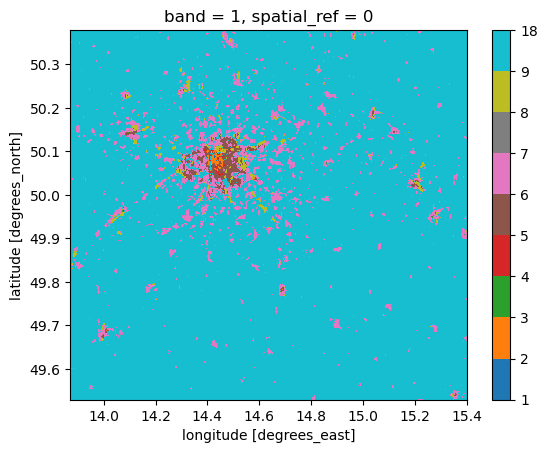

In [14]:
region_lczs.plot(levels=[1,2,3,4,5,6,7,8,9,18], cmap="tab10")

### Crossstab

In [17]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

In [18]:
cluster_mapping

,1,2,3,4,5,6
7,,,,,,
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,2
4,1,1,1,1,1,2
5,1,1,1,1,2,3
...,...,...,...,...,...,...
104,2,4,8,16,31,59
105,2,4,8,16,31,59
106,2,4,8,16,32,60


In [19]:
all_data['map_label'] = all_data['final_without_noise'].map(cluster_mapping[4].to_dict())

In [28]:
lcz_names = {
    "1": "Compact high-rise",
    "2": "Compact mid-rise",
    "3": "Compact low-rise",
    "4": "Open high-rise",
    "5": "Open mid-rise",
    "6": "Open low-rise",
    "7": "Lightweight low-rise",
    "8": "Large low-rise",
    "9": "Sparsely built",
    "10": "Heavy industry",
    "11": "Dense trees",
    "12": "Scattered trees",
    "13": "Bush, scrub",
    "14": "Low plants",
    "15": "Bare rock or paved",
    "16": "Bare soil or sand",
    "17": "Water"
}

lcz_names = {float(k):v for k,v in lcz_names.items()}

In [36]:
all_data.lcz.value_counts() / all_data.shape[0]

lcz
6.0     4.703750e-01
9.0     2.774260e-01
14.0    1.024760e-01
12.0    5.933093e-02
11.0    3.232364e-02
5.0     3.119549e-02
8.0     1.802161e-02
2.0     5.205505e-03
4.0     1.362793e-03
3.0     1.245510e-03
10.0    3.347574e-04
1.0     2.384158e-04
17.0    1.937229e-04
15.0    1.333361e-04
16.0    3.132588e-05
7.0     1.633748e-06
13.0    7.673665e-07
Name: count, dtype: float64

In [29]:
himoc_lcz_tab = pd.crosstab(all_data.map_label, all_data.lcz, normalize='index')
himoc_lcz_tab.index = himoc_lcz_tab.index.map(cluster_4_names).values
himoc_lcz_tab.columns = himoc_lcz_tab.columns.map(lcz_names).values


In [32]:

f = {
    k: "{:.2f}" for k in himoc_lcz_tab.columns.values
}
himoc_lcz_tab.style.format(f).background_gradient(axis=1, cmap="BuGn")

,Compact high-rise,Compact mid-rise,Compact low-rise,Open high-rise,Open mid-rise,Open low-rise,Lightweight low-rise,Large low-rise,Sparsely built,Heavy industry,Dense trees,Scattered trees,"Bush, scrub",Low plants,Bare rock or paved,Bare soil or sand,Water
Dense Connected Developments,0.00,0.01,0.00,0.00,0.10,0.77,0.00,0.02,0.07,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00
Large Interconnected Blocks,0.01,0.23,0.03,0.03,0.25,0.39,0.00,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Extensive Courtyard Complexes,0.15,0.00,0.00,0.01,0.00,0.10,0.00,0.62,0.00,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Massive Connected Aggregations,0.29,0.01,0.00,0.00,0.00,0.01,0.00,0.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dense Standalone Buildings,0.00,0.00,0.00,0.00,0.05,0.80,0.00,0.01,0.11,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00
Compact Development,0.00,0.00,0.00,0.00,0.02,0.81,0.00,0.01,0.14,0.00,0.01,0.01,0.00,0.02,0.00,0.00,0.00
Cul-de-Sac Layout,0.00,0.00,0.00,0.00,0.01,0.53,0.00,0.00,0.33,0.00,0.04,0.05,0.00,0.04,0.00,0.00,0.00
Aligned Winding Streets,0.00,0.00,0.00,0.00,0.01,0.41,0.00,0.01,0.41,0.00,0.03,0.05,0.00,0.09,0.00,0.00,0.00
Sparse Rural Development,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.28,0.00,0.07,0.18,0.00,0.45,0.00,0.00,0.00
Large Wide-Spaced Complexes,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.66,0.03,0.23,0.00,0.00,0.00,0.02,0.00,0.00,0.00


1.  Interesting that we have so many plants and trees, since we only classify buildings. this shows the advatages of higher resolution.
2.  similarly to others larger interconnected and dense connected follow the same patterns as in the others, the other clusters as well.


the biggest differences are that we find structures of developments and characteristics of streets.

in all cases more than 70% of the buildings are assigned to 1 or 2 classes, whereas with our clusters its at most ~30% assigned to the 2 most common clusters. we can go futher down the hierarchy.

In [38]:
all_data.map_label.value_counts() / all_data.shape[0]

map_label
8     0.158218
1     0.141798
6     0.138443
13    0.136718
7     0.109360
14    0.107942
5     0.077025
9     0.045666
12    0.032665
15    0.015308
2     0.015307
16    0.010819
11    0.010673
10    0.000041
3     0.000009
4     0.000009
Name: count, dtype: float64

In [94]:
# building_utm.iloc[160_000: 190_000].explore(column='lcz', categorical=True, prefer_canvas=True, tiles='cartodb positron')